See https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf

Very much research code, absolutely no guarantees on anything

### Imports

In [129]:
%matplotlib inline
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

### Global Constants

In [103]:
NUM_EPOCHS = 100
BATCH_SIZE = 100000
LEARNING_RATE = 0.00005
MOMENTUM = 0.9
REG_CONST = 0.001
NUM_USERS = 480189
NUM_MOVIES = 17770
NUM_LATENT = 10
TRAIN_DATA = '/data/lisatmp4/jethahan/datasets/nflx_full/tf/train.csv'
VAL_DATA = '/data/lisatmp4/jethahan/datasets/nflx_full/tf/val.csv'
TEST_DATA = '/data/lisatmp4/jethahan/datasets/nflx_full/tf/test.csv'

In [33]:
def get_data(filename):
    arr = np.genfromtxt(filename, delimiter=',')
    return arr

### TF Disk Input (not used)

In [27]:
def read_csv_line(filename_queue):
    reader = tf.TextLineReader()
    key, value = reader.read(filename_queue)
    record_defaults = [tf.constant([], dtype=tf.int32),
                       tf.constant([], dtype=tf.int32),
                       tf.constant([], dtype=tf.float32)]
    user_id, movie_id, rating = tf.decode_csv(value, record_defaults=record_defaults)
    return user_id, movie_id, rating

def input_pipeline(filename, batch_size, num_epochs):
    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)
        user_id, movie_id, rating = read_csv_line(filename_queue)
    
        # min_after_dequeue defines how big a buffer we will randomly sample from.
        # Bigger means better shuffling but slower start up and more memory used.
        min_after_dequeue = 10000

        # capacity must be larger than min_after_dequeue and the amount larger
        # determines the maximum we will prefetch.  
        #Recommendation: min_after_dequeue + (num_threads + a small safety margin) * batch_size
        capacity = min_after_dequeue + 3 * batch_size

        #user_id_batch, movie_id_batch, rating_batch = tf.train.shuffle_batch(
        #  [user_id, movie_id, rating], batch_size=batch_size, capacity=capacity,
        #  min_after_dequeue=min_after_dequeue)
        
        user_id_batch, movie_id_batch, rating_batch = tf.train.batch(
         [user_id, movie_id, rating], batch_size=batch_size, capacity=capacity)
    
    return user_id_batch, movie_id_batch, rating_batch

### Load data into memory

In [34]:
print('loading train data into memory')
train_data = get_data(TRAIN_DATA)
print('loaded train')
print('shuffling')
np.random.shuffle(train_data)
print('shuffled')
train_users = train_data[:,0]
train_movies = train_data[:,1]
train_ratings = train_data[:,2]

loading train data into memory
loaded train


In [35]:
print('loading val data into memory')
val_data = get_data(VAL_DATA)
val_users = val_data[:,0]
val_movies = val_data[:,1]
val_ratings = val_data[:,2]
print('loaded val')

loading val data into memory
loaded val


In [106]:
print('loading test data into memory')
test_data = get_data(TEST_DATA)
test_users = test_data[:,0]
test_movies = test_data[:,1]
test_ratings = test_data[:,2]
print('loaded test')

loading test data into memory
loaded test


In [60]:
# RESCALING

#def rescale(x):
    #return (x-1)/4

#rescale = np.vectorize(rescale)

#train_ratings = rescale(train_ratings)

In [ ]:
# MEAN SHIFTING

#mean_rating = train_ratings.mean
#train_ratings = train_ratings - mean_rating

In [111]:
rmses = []
test_rmse = None
total_time = None

### Main TF loop

In [ ]:
def loss(users, user_embedding, movies, movie_embedding, ratings, reg_const):
    latent_users = tf.nn.embedding_lookup(user_embedding, users)
    latent_movies = tf.nn.embedding_lookup(movie_embedding, movies)
    pred_ratings = tf.reduce_sum(tf.mul(latent_users, latent_movies), 1)
    reg = tf.reduce_sum(tf.square(latent_users), 1) + tf.reduce_sum(tf.square(latent_movies), 1)
    loss = tf.reduce_sum((tf.square(ratings - pred_ratings) + tf.mul(reg_const, reg)), 0)
    
    return loss

def calc_rmse(users, user_embedding, movies, movie_embedding, ratings):
    latent_users = tf.nn.embedding_lookup(user_embedding, users)
    latent_movies = tf.nn.embedding_lookup(movie_embedding, movies)
    pred_ratings = tf.reduce_sum(tf.mul(latent_users, latent_movies), 1)
    rmse = tf.sqrt(tf.reduce_mean(tf.square(ratings - pred_ratings)))
    
    return rmse

def get_batch(data_arr, batch_size, batch_ix):
    return data_arr[batch_ix * batch_size : (batch_ix + 1) * batch_size]

graph = tf.Graph()

with graph.as_default():
    
    # Reading from files on disk (see above...)
    #user_ids, movie_ids, ratings = input_pipeline(TRAIN_DATA,
                                                 # batch_size=BATCH_SIZE,
                                                 # num_epochs=NUM_EPOCHS)
    
    users = tf.placeholder(tf.int32)
    movies = tf.placeholder(tf.int32)
    ratings = tf.placeholder(tf.float32)
    
    reg_const = tf.constant(REG_CONST)

    # User/item embedding matrices (initialized to normal noise)
    user_embedding = tf.Variable(tf.mul(0.1, tf.random_normal([NUM_USERS, NUM_LATENT], 0, 1)), name="U")
    movie_embedding = tf.Variable(tf.mul(0.1, tf.random_normal([NUM_MOVIES, NUM_LATENT], 0, 1)), name="V")

    loss = loss(users, user_embedding, movies, movie_embedding, ratings, reg_const)
    
    #train_op = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
    train_op = tf.train.MomentumOptimizer(LEARNING_RATE, MOMENTUM).minimize(loss)
    
    rmse = calc_rmse(users, user_embedding, movies, movie_embedding, ratings)

    init_op = tf.initialize_all_variables()

    #sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    
    sess = tf.Session()
    sess.run(init_op)
    print('Graph Initialized')
    
    # Start input enqueue threads (overkill without disk input)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    try:
        
        print('** Starting training **')
        
        print('Start time %s' % time.asctime(time.localtime(time.time())))
        start_time = time.time()
        
        step = 0
        epoch = 0
        
        rmse_val = sess.run([rmse], feed_dict={users: get_batch(val_users, 8038203, 0),
                                                                  movies: get_batch(val_movies, 8038203, 0),
                                                                  ratings: get_batch(val_ratings, 8038203, 0)})
        
        rmses.append(rmse_val[0])
        print('inital RMSE: %.3f' % rmse_val[0])
        
        while not coord.should_stop():

            _, loss_value = sess.run([train_op, loss], feed_dict={users: get_batch(train_users, BATCH_SIZE, step),
                                                                  movies: get_batch(train_movies, BATCH_SIZE, step),
                                                                  ratings: get_batch(train_ratings, BATCH_SIZE, step)})
            
            
            step += 1
            
            # Hackish...clean up
            if step % 362 == 0:
                print('---- mid-epoch %d -----' % epoch)
            
            if step % 723 == 0:
                # End of training set
                rmse_val = sess.run([rmse], feed_dict={users: get_batch(val_users, 8038203, 0),
                                                                  movies: get_batch(val_movies, 8038203, 0),
                                                                  ratings: get_batch(val_ratings, 8038203, 0)})
                
                rmses.append(rmse_val[0])
                duration = time.time() - start_time
                print("rmse on val set: %.3f --- (%.3f sec avg)" % (rmse_val[0], (duration/(epoch+1))))
                step = 0
                epoch += 1
            
            if epoch == 100:
                rmse_test = sess.run([rmse], feed_dict={users: get_batch(test_users, 20095624, 0),
                                                                  movies: get_batch(test_movies, 20095624, 0),
                                                                  ratings: get_batch(test_ratings, 20095624, 0)})
                test_rmse = rmse_test[0]
                print("rmse on test: %.3f" % test_rmse )
                total_time  = time.time() - start_time
                print("total time: %.3f" % total_time)
                break
                
                
    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (NUM_EPOCHS, step))

    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

Graph Initialized
** Starting training **
Start time Wed Jun 29 19:26:23 2016
inital RMSE: 3.765
---- mid-epoch 0 -----
rmse on val set: 1.676 --- (19.982 sec avg)
---- mid-epoch 1 -----


### Results

In [150]:
print("last val rmse (epoch 100): %.4f" % rmses[-1])
print("test rmse: %.4f" % test_rmse)
print("total time: %d min %.3f sec" % (int(total_time/60), total_time%60))
print("avg epoch time: %.3f sec" % (duration/(epoch+1)))

last val rmse (epoch 100): 0.8444
test rmse: 0.8437
total time: 32 min 46.126 sec
avg epoch time: 19.460 sec


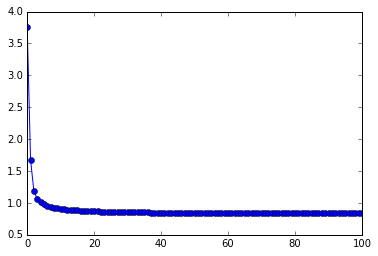

In [143]:
epochs = np.arange(101)
plt.plot(epochs, rmses, '-o')
plt.show()

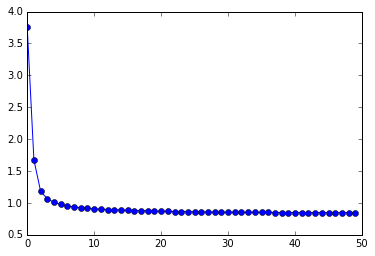

In [144]:
plt.plot(epochs[:50], rmses[:50], '-o')
plt.show()

todo: bias terms... compare perf., etc.